In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import keras
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from tensorflow.keras.layers import Input
from keras.models import Model
from keras.layers import Dense, Conv2D, BatchNormalization, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.utils import plot_model

# Supress info, warnings and error messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [2]:
disease_types = ['COVID', 'Normal']

train_dir = data_dir = '/content/drive/MyDrive/COVID-19_Radiography_Dataset'

train_data = []

for index, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append([sp + "/" + file, index, sp])
        
train = pd.DataFrame(train_data, columns = ['File', 'ID','Disease Type'])
train

,File,ID,Disease Type
0,COVID/COVID-2116.png,0,COVID
1,COVID/COVID-2051.png,0,COVID
2,COVID/COVID-1888.png,0,COVID
3,COVID/COVID-2194.png,0,COVID
4,COVID/COVID-1840.png,0,COVID
...,...,...,...
4702,Normal/Normal-1816.png,1,Normal
4703,Normal/Normal-1876.png,1,Normal
4704,Normal/Normal-1742.png,1,Normal
4705,Normal/Normal-1911.png,1,Normal


,File,ID,Disease Type
0,COVID/COVID-2287.png,0,COVID
1,COVID/COVID-2445.png,0,COVID
2,Normal/Normal-3613.png,1,Normal
3,COVID/COVID-2306.png,0,COVID
4,COVID/COVID-1057.png,0,COVID
...,...,...,...
4702,Normal/Normal-3092.png,1,Normal
4703,Normal/Normal-2756.png,1,Normal
4704,Normal/Normal-2474.png,1,Normal
4705,Normal/Normal-1832.png,1,Normal


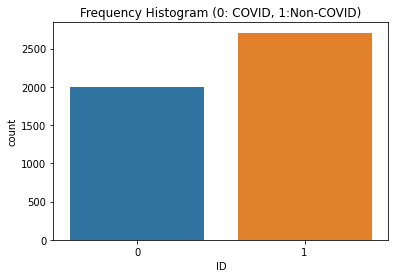

In [3]:
Seed = 40

train = train.sample(frac = 1, replace=False, random_state = Seed)

# Reset indices (row numbers)
train = train.reset_index(drop = True)

sns.countplot(x = "ID", data = train).set_title("Frequency Histogram (0: COVID, 1:Non-COVID)")
train

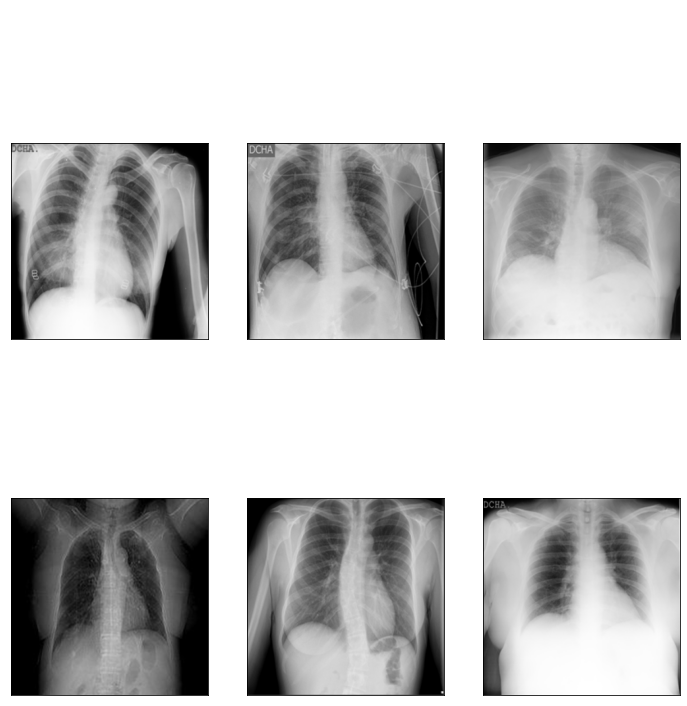

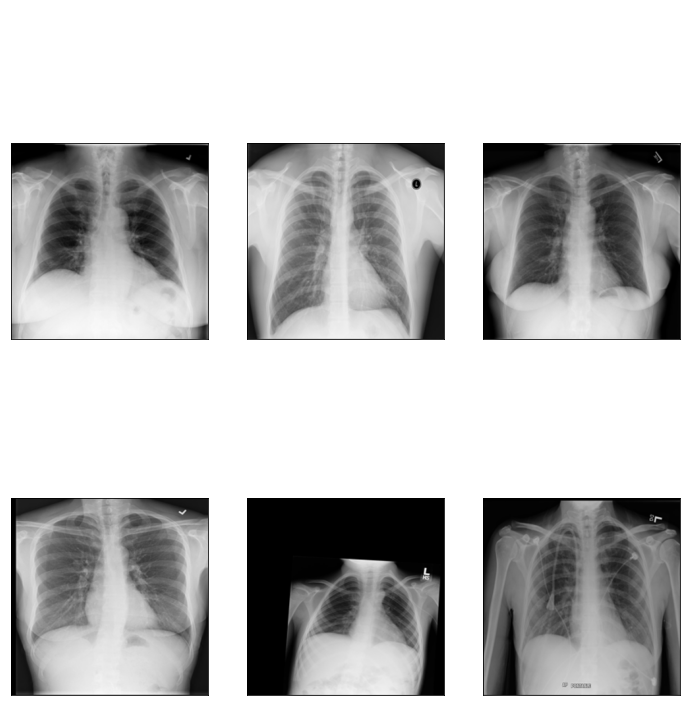

In [4]:
def plot_defects(defect_types, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(12, 12))
    defect_files = train['File'][train['Disease Type'] == defect_types].values
    
    n = 0
    fig.suptitle(defect_types, fontsize = 22, color = "white")
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(data_dir, defect_files[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(image_path))
            n += 1


plot_defects('COVID', 2, 3)
plot_defects('Normal', 2, 3)

In [5]:
IMAGE_SIZE = 224

# OpenCV Function to load colored image
def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath))

# OpenCV Function to resize an image
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation = cv2.INTER_AREA)

In [6]:
X_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))

for i, file in enumerate(train['File'].values):
    image = read_image(file)
    if image is not None:
        X_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))

X_Train = X_train / 255.0   # Pixel normalization
print('Train Shape:', X_Train.shape)

Y_train = to_categorical(train['ID'].values, num_classes = 2)

print(Y_train)

Train Shape: (4707, 224, 224, 3)
[[1. 0.]
 [1. 0.]
 [0. 1.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [7]:
# Dataframe split to train and validation set (80% train and 20% validation)
X_train, X_val, Y_train, Y_val = train_test_split(X_Train,
                                                  Y_train,
                                                  test_size = 0.2, # Percent 20% of the data is using as test set
                                                  random_state = Seed)

print(f'X_train:', X_train.shape)
print(f'X_val:', X_val.shape)
print(f'Y_train:', Y_train.shape)
print(f'Y_val:', Y_val.shape)

X_train: (3765, 224, 224, 3)
X_val: (942, 224, 224, 3)
Y_train: (3765, 2)
Y_val: (942, 2)


# ***DenseNet169***

In [14]:
import tensorflow as tf
import keras
from keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten
from tensorflow.keras.applications import DenseNet169

In [20]:
# Architectural function for DenseNet-169
def build_desnet169(IMAGE_SIZE, channels):

    densetnet169 = DenseNet169(weights = 'imagenet', include_top = False)

    input = Input(shape = (IMAGE_SIZE, IMAGE_SIZE, channels))
    x = Conv2D(3, (3, 3), padding = 'same')(input)
    x = densetnet169(x)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(64, activation = 'relu')(x)
    x = BatchNormalization()(x)
    x = Dense(64, activation = 'relu')(x)
    x = BatchNormalization()(x)
    x = Dense(32, activation = 'relu')(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.BatchNormalization(
                      axis=-1,
                      momentum=0.99,
                      epsilon=0.01,
                      center=True,
                      scale=True,
                      beta_initializer="zeros",
                      gamma_initializer="ones",
                      moving_mean_initializer="zeros",
                      moving_variance_initializer="ones",
                  )(x)
    
    output = Dense(2, activation = 'softmax')(x)
 
    # model
    model = Model(input, output)
    
    optimizer = Adam(learning_rate = 0.001, beta_1 = 0.9, beta_2 = 0.999, epsilon = 0.1, decay = 0.0)
    model.compile(loss = 'binary_crossentropy',  # minimize the negative multinomial log-likelihood also known as the cross-entropy.
                  optimizer = optimizer,
                  metrics = ['accuracy'])
    model.summary()
    
    return model

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 3)       84        
                                                                 
 densenet169 (Functional)    (None, None, None, 1664)  12642880  
                                                                 
 global_average_pooling2d_1   (None, 1664)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 batch_normalization_5 (Batc  (None, 1664)             6656      
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 64)                1065

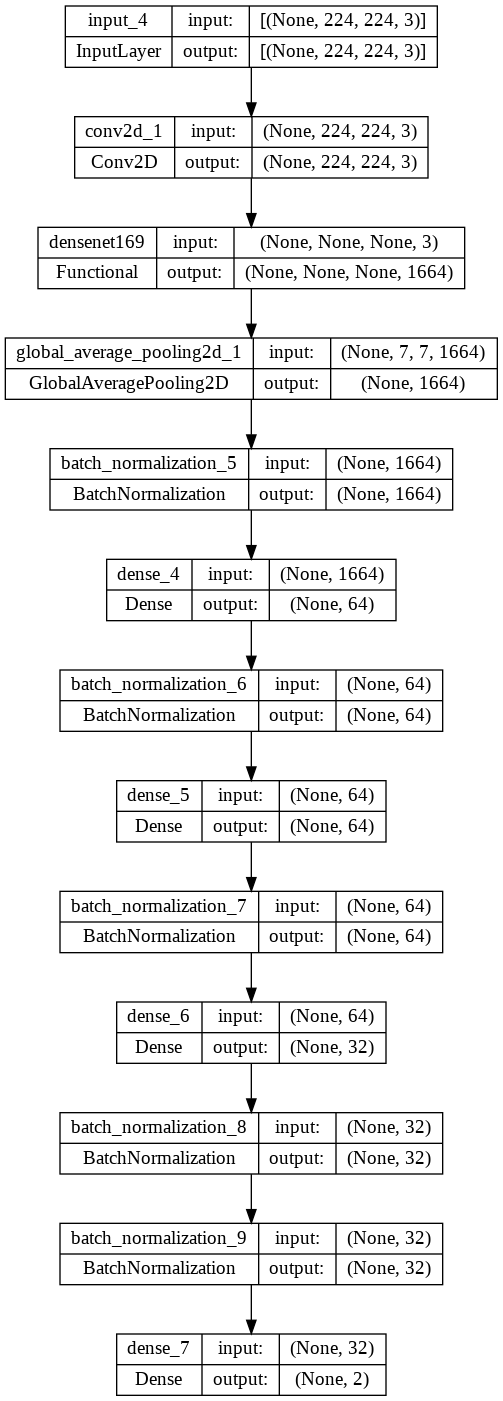

In [21]:
channels = 3

model = build_desnet169(IMAGE_SIZE, channels)
annealer = ReduceLROnPlateau(monitor = 'val_accuracy',  # Reduce learning rate when Validation accuracy remains constant
                             factor = 0.70,  # Rate by which the learning rate will decrease
                             patience = 5,   # number of epochs without improvement, after which the learning rate will decrease
                             verbose = 1,    # Display messages
                             min_lr = 1e-4   # lower limit on the learning rate.
                            )
checkpoint = ModelCheckpoint('model.h5', verbose = 1, save_best_only = True)  # Save neural network weights

# Generates batches of image data with data augmentation
datagen = ImageDataGenerator(rotation_range = 360, # Degree range for random rotations
                        width_shift_range = 0.2,   # Range for random horizontal shifts
                        height_shift_range = 0.2,  # Range for random vertical shifts
                        zoom_range = 0.2,          # Range for random zoom
                        horizontal_flip = True,    # Randomly flip inputs horizontally
                        vertical_flip = True)      # Randomly flip inputs vertically

datagen.fit(X_train)
datagen.fit(X_val)

plot_model(model, to_file = 'densenet.png', show_shapes = True, show_layer_names = True)

In [22]:
BATCH_SIZE = 32
EPOCHS = 100
hist = model.fit(datagen.flow(X_train, Y_train, batch_size = BATCH_SIZE),
               steps_per_epoch = X_train.shape[0] // BATCH_SIZE,
               epochs = EPOCHS,
               verbose = 1,
               callbacks = [annealer, checkpoint],
               validation_data = (X_val, Y_val))

Epoch 1/100
117/117 [==============================] - ETA: 0s - loss: 0.6679 - accuracy: 0.6850
Epoch 1: val_loss improved from inf to 0.72587, saving model to model.h5
117/117 [==============================] - 96s 566ms/step - loss: 0.6679 - accuracy: 0.6850 - val_loss: 0.7259 - val_accuracy: 0.5520 - lr: 0.0010
Epoch 2/100
117/117 [==============================] - ETA: 0s - loss: 0.4572 - accuracy: 0.8245
Epoch 2: val_loss improved from 0.72587 to 0.70726, saving model to model.h5
117/117 [==============================] - 57s 482ms/step - loss: 0.4572 - accuracy: 0.8245 - val_loss: 0.7073 - val_accuracy: 0.5786 - lr: 0.0010
Epoch 3/100
117/117 [==============================] - ETA: 0s - loss: 0.3499 - accuracy: 0.8728
Epoch 3: val_loss improved from 0.70726 to 0.50191, saving model to model.h5
117/117 [==============================] - 57s 482ms/step - loss: 0.3499 - accuracy: 0.8728 - val_loss: 0.5019 - val_accuracy: 0.7919 - lr: 0.0010
Epoch 4/100
117/117 [====================

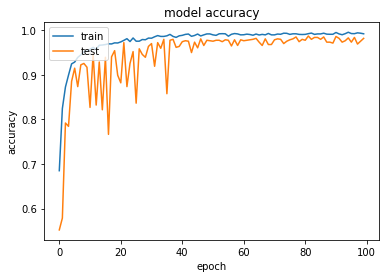

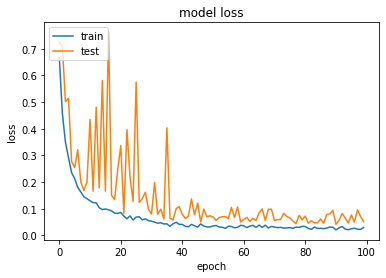

In [23]:
from matplotlib import pyplot as plt
# Accuracy plot 
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

# Loss plot
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

1/1 [==============================] - 3s 3s/step
[1.0000000e+00 3.7134076e-09]


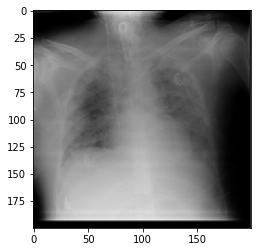

Prediction: Covid


In [24]:
img = keras.utils.load_img('/content/drive/MyDrive/COVID-19_Radiography_Dataset/COVID/COVID-1095.png', grayscale = False, target_size = (IMAGE_SIZE, IMAGE_SIZE))
show_img = keras.utils.load_img('/content/drive/MyDrive/COVID-19_Radiography_Dataset/COVID/COVID-1095.png', grayscale = False, target_size = (200, 200))
disease_class = ['Covid','Normal','Viral Pneumonia']
x = keras.utils.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x /= 255

custom = model.predict(x)
print(custom[0])

plt.imshow(show_img)
plt.show()

a = custom[0]
ind = np.argmax(a)
        
print('Prediction:',disease_class[ind])

30/30 [==============================] - 3s 112ms/step
True Positive: 531
False Negative: 3
True Negative: 394
False Positive: 14
True Positive Rate: 0.9943820224719101
True Negative Rate: 0.9656862745098039

30/30 [==============================] - 3s 114ms/step - loss: 0.0518 - accuracy: 0.9820

Final Loss: 0.05176689103245735, Final Accuracy: 0.9819532632827759


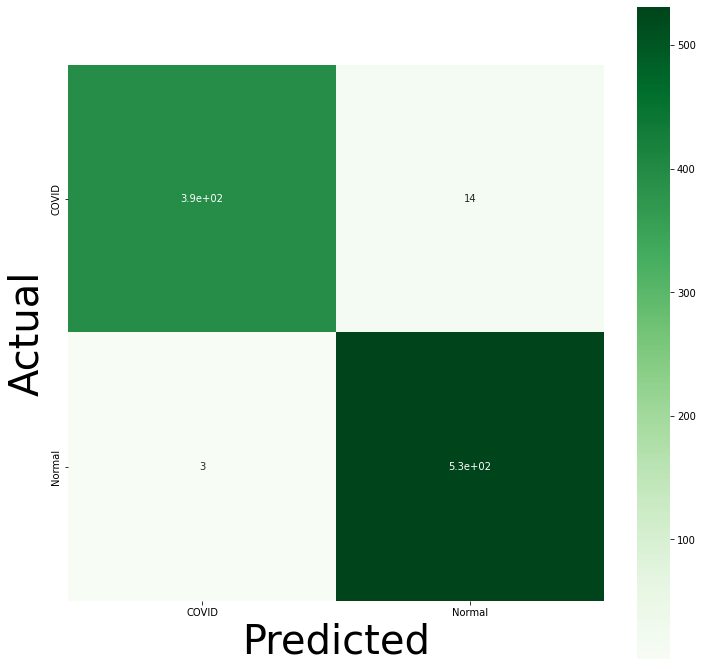

In [25]:
Y_pred = model.predict(X_val)

Y_pred = np.argmax(Y_pred, axis = 1)
Y_true = np.argmax(Y_val, axis = 1)

cm = confusion_matrix(Y_true, Y_pred)
plt.figure(figsize = (12, 12))
ax = sns.heatmap(cm, cmap = plt.cm.Greens, annot = True, square = True, xticklabels = disease_types, yticklabels = disease_types)
ax.set_ylabel('Actual', fontsize = 40)
ax.set_xlabel('Predicted', fontsize = 40)


TP = cm[1][1]
print(f"True Positive: {TP}")


FN = cm[1][0]
print(f"False Negative: {FN}")

TN = cm[0][0]
print(f"True Negative: {TN}")

FP = cm[0][1]
print(f"False Positive: {FP}")

# Sensitivity, recall, or true positive rate
print(f"True Positive Rate: {TP / (TP + FN)}")

# Specificity or true negative rate
print(f"True Negative Rate: {TN / (TN + FP)}\n")

final_loss, final_accuracy = model.evaluate(X_val, Y_val)
print(f"\nFinal Loss: {final_loss}, Final Accuracy: {final_accuracy}")

In [26]:
model.save('saved_model/model1.hdf5')

In [27]:
from keras.models import load_model
from sklearn.metrics import accuracy_score

model1 = load_model('saved_model/model1.hdf5')

In [28]:
testX_arg = np.argmax(X_val, axis=1)
y_pred = np.argmax(model.predict(X_val), axis=1)
y_true = np.argmax(Y_val, axis=1)
accuracy1 = accuracy_score(y_true, y_pred)
print(accuracy1)
print(y_pred.shape)

30/30 [==============================] - 3s 112ms/step
0.9819532908704883
(942,)


In [29]:
print('Accuracy Score for model1 = ', accuracy1)

Accuracy Score for model1 =  0.9819532908704883


In [30]:
from sklearn.metrics import classification_report
print(classification_report(Y_true, Y_pred))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       408
           1       0.97      0.99      0.98       534

    accuracy                           0.98       942
   macro avg       0.98      0.98      0.98       942
weighted avg       0.98      0.98      0.98       942



# ***Xception***

In [31]:
import tensorflow as tf
import keras
from keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten
from tensorflow.keras.applications import Xception

In [33]:
# Architectural function for DenseNet-169
def build_xception(IMAGE_SIZE, channels):

    xception = Xception(weights = 'imagenet', include_top = False)

    input = Input(shape = (IMAGE_SIZE, IMAGE_SIZE, channels))
    x = Conv2D(3, (3, 3), padding = 'same')(input)
    x = xception(x)
    x = GlobalAveragePooling2D()(x)
    x =tf.keras.layers.Dropout(0.50)(x)
    x = BatchNormalization()(x)
    x = Dense(128, activation = 'relu')(x)
    x =tf.keras.layers.Dropout(0.50)(x)
    x = Dense(128, activation = 'relu')(x)
    x =tf.keras.layers.Dropout(0.50)(x)
    x = Dense(64, activation = 'relu')(x)
    x =tf.keras.layers.Dropout(0.50)(x)
    x = tf.keras.layers.BatchNormalization(
                      axis=-1,
                      momentum=0.99,
                      epsilon=0.01,
                      center=True,
                      scale=True,
                      beta_initializer="zeros",
                      gamma_initializer="ones",
                      moving_mean_initializer="zeros",
                      moving_variance_initializer="ones",
                  )(x)
    
    output = Dense(2, activation = 'softmax')(x)
 
    # model
    model = Model(input, output)
    
    optimizer = Adam(learning_rate = 0.001, beta_1 = 0.9, beta_2 = 0.999, epsilon = 0.1, decay = 0.0)
    model.compile(loss = 'binary_crossentropy',  # minimize the negative multinomial log-likelihood also known as the cross-entropy.
                  optimizer = optimizer,
                  metrics = ['accuracy'])
    model.summary()
    
    return model

83683744/83683744 [==============================] - 3s 0us/step
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_6 (Conv2D)           (None, 224, 224, 3)       84        
                                                                 
 xception (Functional)       (None, None, None, 2048)  20861480  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 batch_normalization_14 (Bat  (None, 2048)             8192 

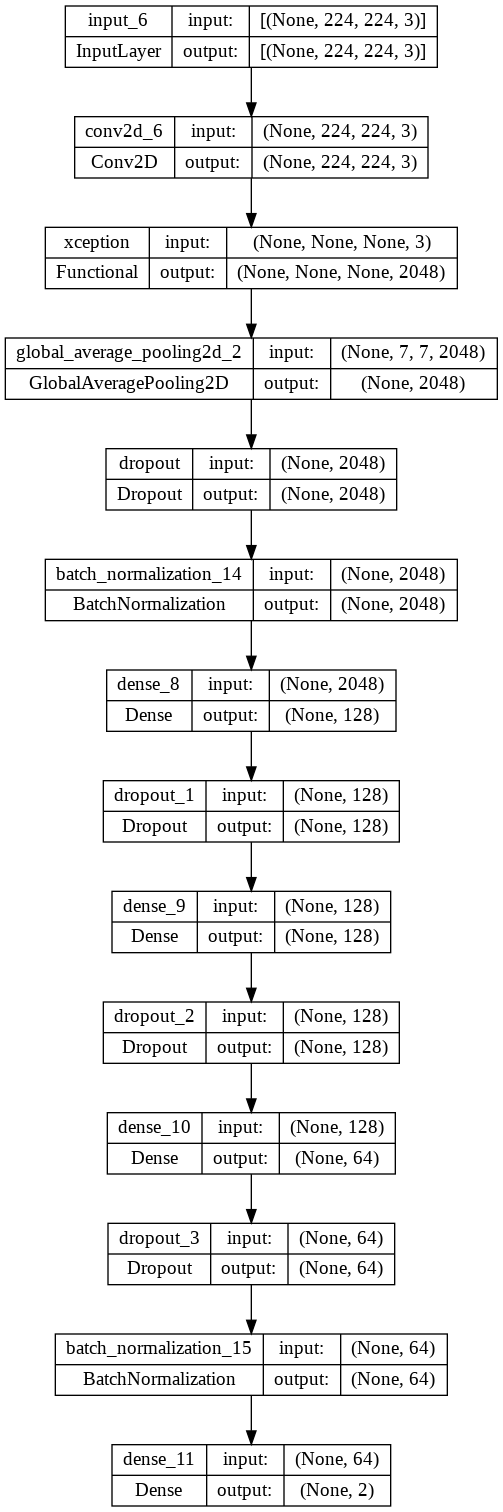

In [34]:
channels = 3

model = build_xception(IMAGE_SIZE, channels)
annealer = ReduceLROnPlateau(monitor = 'val_accuracy',  # Reduce learning rate when Validation accuracy remains constant
                             factor = 0.70,  # Rate by which the learning rate will decrease
                             patience = 5,   # number of epochs without improvement, after which the learning rate will decrease
                             verbose = 1,    # Display messages
                             min_lr = 1e-4   # lower limit on the learning rate.
                            )
checkpoint = ModelCheckpoint('model2.h5', verbose = 1, save_best_only = True)  # Save neural network weights

# Generates batches of image data with data augmentation
datagen = ImageDataGenerator(rotation_range = 360, # Degree range for random rotations
                        width_shift_range = 0.2,   # Range for random horizontal shifts
                        height_shift_range = 0.2,  # Range for random vertical shifts
                        zoom_range = 0.2,          # Range for random zoom
                        horizontal_flip = True,    # Randomly flip inputs horizontally
                        vertical_flip = True)      # Randomly flip inputs vertically


datagen.fit(X_train)
datagen.fit(X_val)

plot_model(model, to_file = 'xception.png', show_shapes = True, show_layer_names = True)

In [35]:
BATCH_SIZE = 32
EPOCHS = 100

# Fit of the model that includes the augmented images in terms of their characteristics
hist = model.fit(datagen.flow(X_train, Y_train, batch_size = BATCH_SIZE),
               steps_per_epoch = X_train.shape[0] // BATCH_SIZE,
               epochs = EPOCHS,
               verbose = 1,
               callbacks = [annealer, checkpoint],
               validation_data = (X_val, Y_val))

Epoch 1/100
117/117 [==============================] - ETA: 0s - loss: 0.8769 - accuracy: 0.4996
Epoch 1: val_loss improved from inf to 0.67973, saving model to model2.h5
117/117 [==============================] - 90s 695ms/step - loss: 0.8769 - accuracy: 0.4996 - val_loss: 0.6797 - val_accuracy: 0.5658 - lr: 0.0010
Epoch 2/100
117/117 [==============================] - ETA: 0s - loss: 0.8414 - accuracy: 0.5315
Epoch 2: val_loss improved from 0.67973 to 0.67077, saving model to model2.h5
117/117 [==============================] - 77s 658ms/step - loss: 0.8414 - accuracy: 0.5315 - val_loss: 0.6708 - val_accuracy: 0.6423 - lr: 0.0010
Epoch 3/100
117/117 [==============================] - ETA: 0s - loss: 0.7904 - accuracy: 0.5567
Epoch 3: val_loss improved from 0.67077 to 0.63418, saving model to model2.h5
117/117 [==============================] - 77s 654ms/step - loss: 0.7904 - accuracy: 0.5567 - val_loss: 0.6342 - val_accuracy: 0.7219 - lr: 0.0010
Epoch 4/100
117/117 [=================

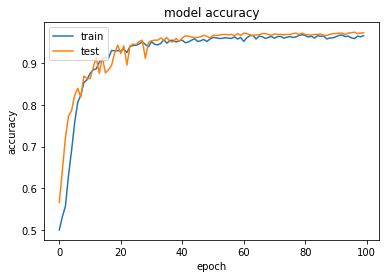

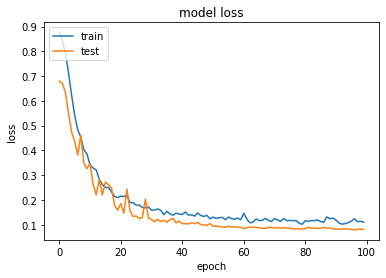

In [36]:
from matplotlib import pyplot as plt
# Accuracy plot 
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

# Loss plot
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

1/1 [==============================] - 1s 1s/step
[9.999964e-01 3.599741e-06]


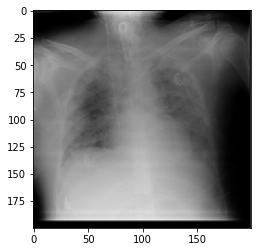

Prediction: Covid


In [37]:
img = keras.utils.load_img('/content/drive/MyDrive/COVID-19_Radiography_Dataset/COVID/COVID-1095.png', grayscale = False, target_size = (IMAGE_SIZE, IMAGE_SIZE))
show_img = keras.utils.load_img('/content/drive/MyDrive/COVID-19_Radiography_Dataset/COVID/COVID-1095.png', grayscale = False, target_size = (200, 200))
disease_class = ['Covid','Normal','Viral Pneumonia']
x = keras.utils.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x /= 255

custom = model.predict(x)
print(custom[0])

plt.imshow(show_img)
plt.show()

a = custom[0]
ind = np.argmax(a)
        
print('Prediction:',disease_class[ind])

30/30 [==============================] - 4s 128ms/step
True Positive: 531
False Negative: 3
True Negative: 386
False Positive: 22
True Positive Rate: 0.9943820224719101
True Negative Rate: 0.946078431372549

30/30 [==============================] - 4s 126ms/step - loss: 0.0816 - accuracy: 0.9735

Final Loss: 0.08155132830142975, Final Accuracy: 0.9734607338905334


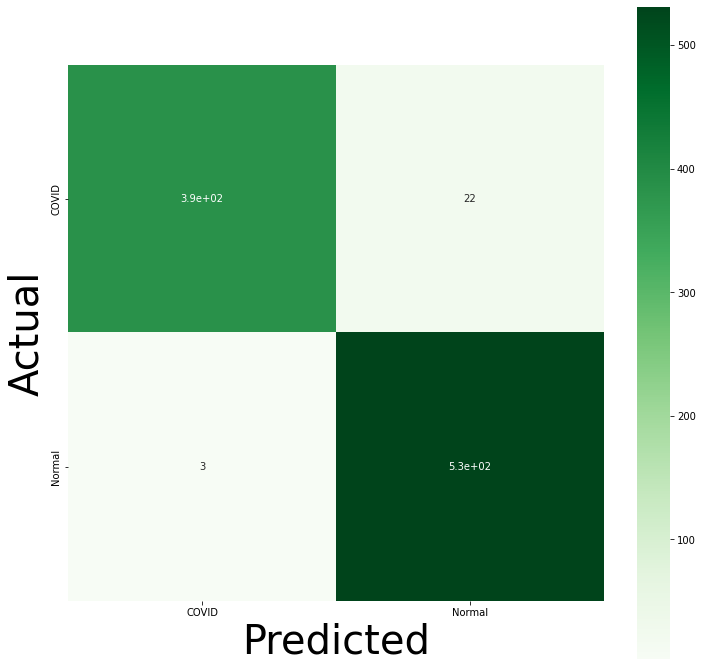

In [54]:
Y_pred = model.predict(X_val)

Y_pred = np.argmax(Y_pred, axis = 1)
Y_true = np.argmax(Y_val, axis = 1)

cm = confusion_matrix(Y_true, Y_pred)
plt.figure(figsize = (12, 12))
ax = sns.heatmap(cm, cmap = plt.cm.Greens, annot = True, square = True, xticklabels = disease_types, yticklabels = disease_types)
ax.set_ylabel('Actual', fontsize = 40)
ax.set_xlabel('Predicted', fontsize = 40)


TP = cm[1][1]
print(f"True Positive: {TP}")


FN = cm[1][0]
print(f"False Negative: {FN}")

TN = cm[0][0]
print(f"True Negative: {TN}")

FP = cm[0][1]
print(f"False Positive: {FP}")

# Sensitivity, recall, or true positive rate
print(f"True Positive Rate: {TP / (TP + FN)}")

# Specificity or true negative rate
print(f"True Negative Rate: {TN / (TN + FP)}\n")

final_loss, final_accuracy = model.evaluate(X_val, Y_val)
print(f"\nFinal Loss: {final_loss}, Final Accuracy: {final_accuracy}")

In [40]:
model.save('saved_model/model2.hdf5')

In [41]:
from keras.models import load_model
from sklearn.metrics import accuracy_score

model1 = load_model('saved_model/model2.hdf5')

In [42]:
testX_arg = np.argmax(X_val, axis=1)
y_pred = np.argmax(model1.predict(X_val), axis=1)
y_true = np.argmax(Y_val, axis=1)
accuracy1 = accuracy_score(y_true, y_pred)
print(accuracy1)
print(y_pred.shape)

30/30 [==============================] - 4s 128ms/step
0.9734607218683652
(942,)


In [43]:
print('Accuracy Score for model2 = ', accuracy1)

Accuracy Score for model2 =  0.9734607218683652


In [44]:
from sklearn.metrics import classification_report
print(classification_report(Y_true, Y_pred))

              precision    recall  f1-score   support

           0       0.99      0.95      0.97       408
           1       0.96      0.99      0.98       534

    accuracy                           0.97       942
   macro avg       0.98      0.97      0.97       942
weighted avg       0.97      0.97      0.97       942



# ***VGG16***

In [8]:
import tensorflow as tf
import keras
from keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten
from tensorflow.keras.applications import VGG16

In [9]:
# Architectural function for DenseNet-169
def build_vgg16(IMAGE_SIZE, channels):

    vgg16 = VGG16(weights = 'imagenet', include_top = False)

    input = Input(shape = (IMAGE_SIZE, IMAGE_SIZE, channels))
    x = Conv2D(3, (3, 3), padding = 'same')(input)
    x = vgg16(x)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(128, activation = 'relu')(x)
    x = BatchNormalization()(x)
    x = Dense(64, activation = 'relu')(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.BatchNormalization(
                      axis=-1,
                      momentum=0.99,
                      epsilon=0.01,
                      center=True,
                      scale=True,
                      beta_initializer="zeros",
                      gamma_initializer="ones",
                      moving_mean_initializer="zeros",
                      moving_variance_initializer="ones",
                  )(x)
    
    output = Dense(2, activation = 'softmax')(x)
 
    # model
    model = Model(input, output)
    
    optimizer = Adam(learning_rate = 0.001, beta_1 = 0.9, beta_2 = 0.999, epsilon = 0.1, decay = 0.0)
    model.compile(loss = 'binary_crossentropy',  # minimize the negative multinomial log-likelihood also known as the cross-entropy.
                  optimizer = optimizer,
                  metrics = ['accuracy'])
    model.summary()
    
    return model

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 3)       84        
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 128)               65664 

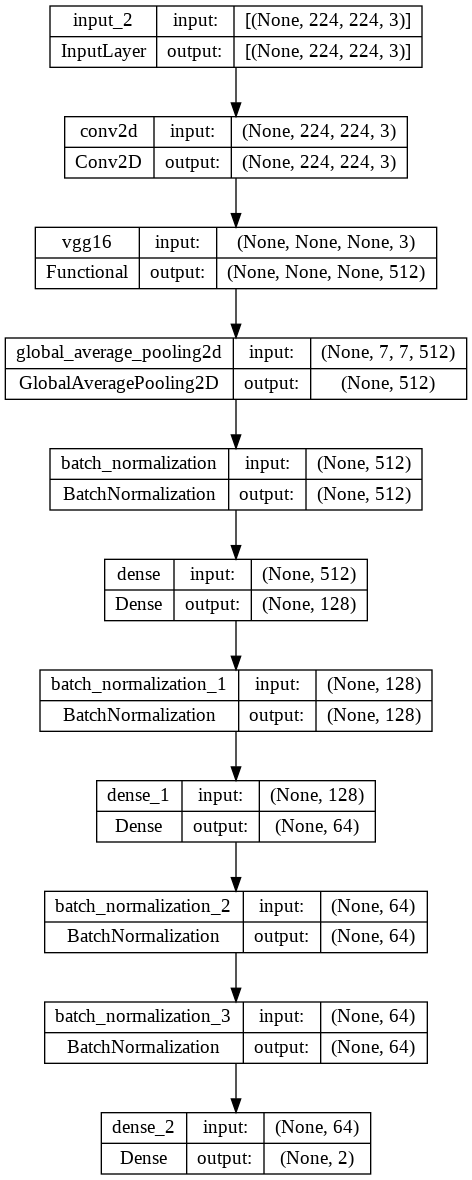

In [10]:
channels = 3

model = build_vgg16(IMAGE_SIZE, channels)
annealer = ReduceLROnPlateau(monitor = 'val_accuracy',  # Reduce learning rate when Validation accuracy remains constant
                             factor = 0.70,  # Rate by which the learning rate will decrease
                             patience = 5,   # number of epochs without improvement, after which the learning rate will decrease
                             verbose = 1,    # Display messages
                             min_lr = 1e-4   # lower limit on the learning rate.
                            )
checkpoint = ModelCheckpoint('model3.h5', verbose = 1, save_best_only = True)  # Save neural network weights

# Generates batches of image data with data augmentation
datagen = ImageDataGenerator(rotation_range = 360, # Degree range for random rotations
                        width_shift_range = 0.2,   # Range for random horizontal shifts
                        height_shift_range = 0.2,  # Range for random vertical shifts
                        zoom_range = 0.2,          # Range for random zoom
                        horizontal_flip = True,    # Randomly flip inputs horizontally
                        vertical_flip = True)      # Randomly flip inputs vertically

datagen.fit(X_train)
datagen.fit(X_val)

plot_model(model, to_file = 'vgg16.png', show_shapes = True, show_layer_names = True)

In [11]:
BATCH_SIZE = 32
EPOCHS = 100

# Fit of the model that includes the augmented images in terms of their characteristics
hist = model.fit(datagen.flow(X_train, Y_train, batch_size = BATCH_SIZE),
               steps_per_epoch = X_train.shape[0] // BATCH_SIZE,
               epochs = EPOCHS,
               verbose = 1,
               callbacks = [annealer, checkpoint],
               validation_data = (X_val, Y_val))

Epoch 1/100
117/117 [==============================] - ETA: 0s - loss: 0.5749 - accuracy: 0.7522
Epoch 1: val_loss improved from inf to 0.59553, saving model to model3.h5
117/117 [==============================] - 83s 549ms/step - loss: 0.5749 - accuracy: 0.7522 - val_loss: 0.5955 - val_accuracy: 0.6369 - lr: 0.0010
Epoch 2/100
117/117 [==============================] - ETA: 0s - loss: 0.3977 - accuracy: 0.8310
Epoch 2: val_loss did not improve from 0.59553
117/117 [==============================] - 56s 478ms/step - loss: 0.3977 - accuracy: 0.8310 - val_loss: 0.6261 - val_accuracy: 0.6062 - lr: 0.0010
Epoch 3/100
117/117 [==============================] - ETA: 0s - loss: 0.3428 - accuracy: 0.8578
Epoch 3: val_loss improved from 0.59553 to 0.35297, saving model to model3.h5
117/117 [==============================] - 57s 482ms/step - loss: 0.3428 - accuracy: 0.8578 - val_loss: 0.3530 - val_accuracy: 0.8301 - lr: 0.0010
Epoch 4/100
117/117 [==============================] - ETA: 0s - loss

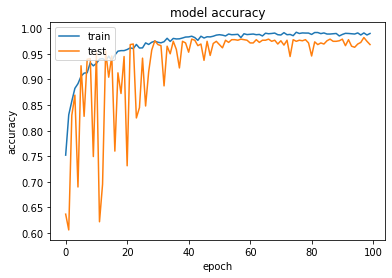

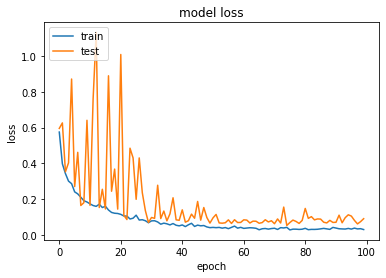

In [12]:
from matplotlib import pyplot as plt
# Accuracy plot 
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

# Loss plot
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

1/1 [==============================] - 1s 916ms/step
[1.0000000e+00 1.5483396e-08]


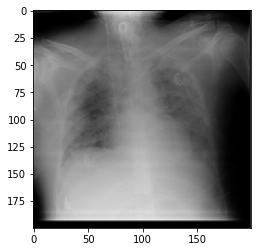

Prediction: Covid


In [13]:
img = keras.utils.load_img('/content/drive/MyDrive/COVID-19_Radiography_Dataset/COVID/COVID-1095.png', grayscale = False, target_size = (IMAGE_SIZE, IMAGE_SIZE))
show_img = keras.utils.load_img('/content/drive/MyDrive/COVID-19_Radiography_Dataset/COVID/COVID-1095.png', grayscale = False, target_size = (200, 200))
disease_class = ['Covid','Normal','Viral Pneumonia']
x = keras.utils.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x /= 255

custom = model.predict(x)
print(custom[0])

plt.imshow(show_img)
plt.show()

a = custom[0]
ind = np.argmax(a)
        
print('Prediction:',disease_class[ind])

30/30 [==============================] - 4s 151ms/step
True Positive: 536
False Negative: 4
True Negative: 376
False Positive: 26
True Positive Rate: 0.9925925925925926
True Negative Rate: 0.9353233830845771

30/30 [==============================] - 5s 152ms/step - loss: 0.0908 - accuracy: 0.9682

Final Loss: 0.0908050462603569, Final Accuracy: 0.9681528806686401


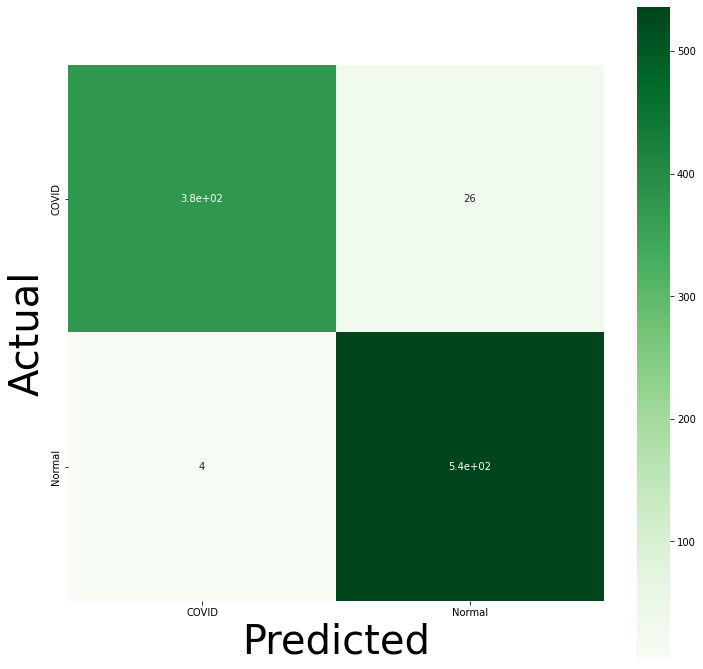

In [14]:
Y_pred = model.predict(X_val)

Y_pred = np.argmax(Y_pred, axis = 1)
Y_true = np.argmax(Y_val, axis = 1)

cm = confusion_matrix(Y_true, Y_pred)
plt.figure(figsize = (12, 12))
ax = sns.heatmap(cm, cmap = plt.cm.Greens, annot = True, square = True, xticklabels = disease_types, yticklabels = disease_types)
ax.set_ylabel('Actual', fontsize = 40)
ax.set_xlabel('Predicted', fontsize = 40)


TP = cm[1][1]
print(f"True Positive: {TP}")


FN = cm[1][0]
print(f"False Negative: {FN}")

TN = cm[0][0]
print(f"True Negative: {TN}")

FP = cm[0][1]
print(f"False Positive: {FP}")

# Sensitivity, recall, or true positive rate
print(f"True Positive Rate: {TP / (TP + FN)}")

# Specificity or true negative rate
print(f"True Negative Rate: {TN / (TN + FP)}\n")

final_loss, final_accuracy = model.evaluate(X_val, Y_val)
print(f"\nFinal Loss: {final_loss}, Final Accuracy: {final_accuracy}")

In [15]:
model.save('saved_model/model3.hdf5')

In [16]:
from keras.models import load_model
from sklearn.metrics import accuracy_score

model2 = load_model('saved_model/model3.hdf5')

In [17]:
testX_arg = np.argmax(X_val, axis=1)
y_pred = np.argmax(model2.predict(X_val), axis=1)
y_true = np.argmax(Y_val, axis=1)
accuracy1 = accuracy_score(y_true, y_pred)
print(accuracy1)
print(y_pred.shape)

30/30 [==============================] - 5s 153ms/step
0.9681528662420382
(942,)


In [18]:
print('Accuracy Score for model3 = ', accuracy1)

Accuracy Score for model3 =  0.9681528662420382


In [19]:
from sklearn.metrics import classification_report
print(classification_report(Y_true, Y_pred))

              precision    recall  f1-score   support

           0       0.99      0.94      0.96       402
           1       0.95      0.99      0.97       540

    accuracy                           0.97       942
   macro avg       0.97      0.96      0.97       942
weighted avg       0.97      0.97      0.97       942



# ***Ensemble***

In [21]:
model1 = load_model('saved_model/model1.hdf5')
model2 = load_model('saved_model/model2.hdf5')
model3 = load_model('saved_model/model3.hdf5')

models = [model1, model2, model3]

In [22]:
preds = [model.predict(X_val) for model in models]
preds=np.array(preds)
summed = np.sum(preds, axis=0)

30/30 [==============================] - 5s 154ms/step


In [23]:
# argmax across classes
ensemble_prediction = np.argmax(summed, axis=1)

In [24]:
testX_arg = np.argmax(X_val, axis=1)
y_true = np.argmax(Y_val, axis=1)
accuracy1 = accuracy_score(y_true, ensemble_prediction)
print("Ensemble Accuracy:")
print(accuracy1)
print(y_pred.shape)

Ensemble Accuracy:
0.9851380042462845
(942,)


In [25]:
testX_arg1 = np.argmax(X_val, axis=1)
y_pred1 = np.argmax(model1.predict(X_val), axis=1)
y_true1 = np.argmax(Y_val, axis=1)
accuracy1 = accuracy_score(y_true1, y_pred1)


testX_arg2 = np.argmax(X_val, axis=1)
y_pred2 = np.argmax(model2.predict(X_val), axis=1)
y_true2 = np.argmax(Y_val, axis=1)
accuracy2 = accuracy_score(y_true2, y_pred2)


testX_arg3 = np.argmax(X_val, axis=1)
y_pred3 = np.argmax(model3.predict(X_val), axis=1)
y_true3 = np.argmax(Y_val, axis=1)
accuracy3 = accuracy_score(y_true3, y_pred3)

30/30 [==============================] - 4s 153ms/step


In [26]:
testX_arg = np.argmax(X_val, axis=1)
y_true4 = np.argmax(Y_val, axis=1)
accuracy4 = accuracy_score(y_true4, ensemble_prediction)
print("Ensemble Accuracy:")
print(accuracy4)
print(y_pred.shape)

Ensemble Accuracy:
0.9851380042462845
(942,)


In [27]:
print('Accuracy Score for model1 = ', accuracy1)
print('Accuracy Score for model2 = ', accuracy2)
print('Accuracy Score for model3 = ', accuracy3)
print('Accuracy Score for Ensemble = ', accuracy4)

Accuracy Score for model1 =  0.9872611464968153
Accuracy Score for model2 =  0.9713375796178344
Accuracy Score for model3 =  0.9681528662420382
Accuracy Score for Ensemble =  0.9851380042462845


In [28]:
testX_arg = np.argmax(X_val, axis=1)
y_true4 = np.argmax(Y_val, axis=1)
accuracy4 = accuracy_score(y_true4, ensemble_prediction)
print("Ensemble Accuracy:")
print(accuracy4)

Ensemble Accuracy:
0.9851380042462845


In [29]:
from sklearn.metrics import classification_report
print(classification_report(y_true4, ensemble_prediction))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       402
           1       0.98      1.00      0.99       540

    accuracy                           0.99       942
   macro avg       0.99      0.98      0.98       942
weighted avg       0.99      0.99      0.99       942



True Positive: 538
False Negative: 2
True Negative: 390
False Positive: 12
True Positive Rate: 0.9962962962962963
True Negative Rate: 0.9701492537313433



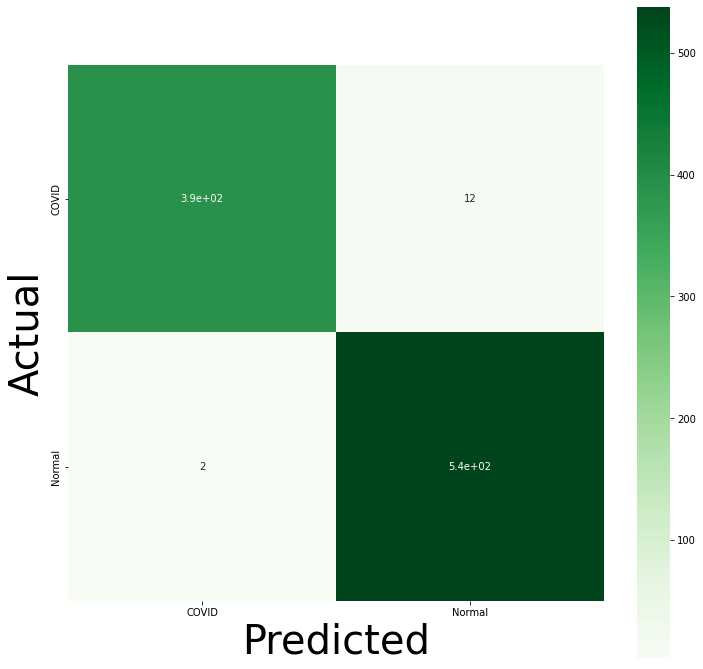

In [30]:
cm = confusion_matrix(y_true4, ensemble_prediction)
plt.figure(figsize = (12, 12))
ax = sns.heatmap(cm, cmap = plt.cm.Greens, annot = True, square = True, xticklabels = disease_types, yticklabels = disease_types)
ax.set_ylabel('Actual', fontsize = 40)
ax.set_xlabel('Predicted', fontsize = 40)


TP = cm[1][1]
print(f"True Positive: {TP}")


FN = cm[1][0]
print(f"False Negative: {FN}")

TN = cm[0][0]
print(f"True Negative: {TN}")

FP = cm[0][1]
print(f"False Positive: {FP}")

# Sensitivity, recall, or true positive rate
print(f"True Positive Rate: {TP / (TP + FN)}")

# Specificity or true negative rate
print(f"True Negative Rate: {TN / (TN + FP)}\n")

In [31]:
from sklearn.metrics import classification_report
print(classification_report(Y_true, Y_pred))

              precision    recall  f1-score   support

           0       0.99      0.94      0.96       402
           1       0.95      0.99      0.97       540

    accuracy                           0.97       942
   macro avg       0.97      0.96      0.97       942
weighted avg       0.97      0.97      0.97       942



In [65]:
models = [model1, model2, model3]
preds = [model.predict(X_val) for model in models]
preds=np.array(preds)
weights = [0.4, 0.4, 0.0]

30/30 [==============================] - 4s 151ms/step


In [66]:
weighted_preds = np.tensordot(preds, weights, axes=((0),(0)))
y_true = np.argmax(Y_val, axis=1)
weighted_ensemble_prediction = np.argmax(weighted_preds, axis=1)

weighted_accuracy = accuracy_score(y_true, weighted_ensemble_prediction)

In [67]:
print('Accuracy Score for model1 = ', accuracy1)
print('Accuracy Score for model2 = ', accuracy2)
print('Accuracy Score for model3 = ', accuracy3)
print('Accuracy Score for average ensemble = ', accuracy4)
print('Accuracy Score for weighted average ensemble = ', weighted_accuracy)

Accuracy Score for model1 =  0.9872611464968153
Accuracy Score for model2 =  0.9713375796178344
Accuracy Score for model3 =  0.9681528662420382
Accuracy Score for average ensemble =  0.9851380042462845
Accuracy Score for weighted average ensemble =  0.9915074309978769


In [62]:
models = [model1, model2, model3]
preds1 = [model.predict(X_val) for model in models]
preds1=np.array(preds1)
y_true = np.argmax(Y_val, axis=1)
import pandas as pd
df = pd.DataFrame([])

for w1 in range(0, 5):
    for w2 in range(0,5):
        for w3 in range(0,5):
            wts = [w1/10., w2/10.,w3/10.]
            wted_preds1 = np.tensordot(preds1, wts, axes=((0),(0)))
            wted_ensemble_pred = np.argmax(wted_preds1, axis=1)
            weighted_accuracy = accuracy_score(y_true, wted_ensemble_pred)
            df = df.append(pd.DataFrame({'wt1':wts[0],'wt2':wts[1], 
                                         'wt3':wts[2], 'acc':weighted_accuracy*100}, index=[0]), ignore_index=True)
            
  

30/30 [==============================] - 4s 151ms/step
Max accuracy of  0.1  obained with w1= 0.1  w2= 0.0  and w3= 99.15074309978769


In [64]:
max_acc_row = df.iloc[df['acc'].idxmax()]
print("Max accuracy of ", max_acc_row[0], " obained with w1=", max_acc_row[1], " w2=", max_acc_row[2], " and w3=", max_acc_row[3])  

Max accuracy of  0.1  obained with w1= 0.1  w2= 0.0  and w3= 99.15074309978769


In [63]:
df.style

,wt1,wt2,wt3,acc
0,0.000000,0.000000,0.000000,42.675159
1,0.000000,0.000000,0.100000,96.815287
2,0.000000,0.000000,0.200000,96.815287
3,0.000000,0.000000,0.300000,96.815287
4,0.000000,0.000000,0.400000,96.815287
5,0.000000,0.100000,0.000000,97.133758
6,0.000000,0.100000,0.100000,97.770701
7,0.000000,0.100000,0.200000,97.346072
8,0.000000,0.100000,0.300000,97.346072
9,0.000000,0.100000,0.400000,97.239915
